In [1]:
# 设置工作目录为 "../../"
import os
os.chdir("../../")

In [5]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import orbax.checkpoint as ocp
from jax import jit, random, vmap
import re
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from matplotlib import font_manager

# load the font
font_dir = "./fonts/"
font_names = os.listdir(font_dir)
for font_name in font_names:
    font_manager.fontManager.addfont(font_dir + font_name)

rcParams.update({
    "font.size": 16,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype"],
    "mathtext.fontset": "cm",
})
# jax.config.update("jax_enable_x64", True)  # 启用 float64 精度


In [6]:
import examples.genes_propagation.configs as cfg
from examples.genes_propagation.model import PINN

cfg = cfg.Config()
pinn = PINN(
    config=cfg,
)

ref_path = cfg.DATA_PATH
mesh_fem = jnp.load(f"{cfg.DATA_PATH}/mesh.npy")
times_fem = jnp.load(f"{cfg.DATA_PATH}/times.npy")
sol = jnp.load(f"{cfg.DATA_PATH}/sol.npy")

mesh = mesh_fem / cfg.Lc
times = times_fem / cfg.Tc

mesh.shape, times.shape, sol.shape

((1001,), (101,), (101, 1001))

In [7]:
ckpt = ocp.StandardCheckpointer()
state = ckpt.restore("/root/autodl-tmp/tf-logs/genes_prop/irr/baseline-40k/model-40000/")
state_noirr = ckpt.restore("/root/autodl-tmp/tf-logs/genes_prop/noirr/baseline-40k/model-40000/")
params = state["params"]
params_noirr = state_noirr["params"]

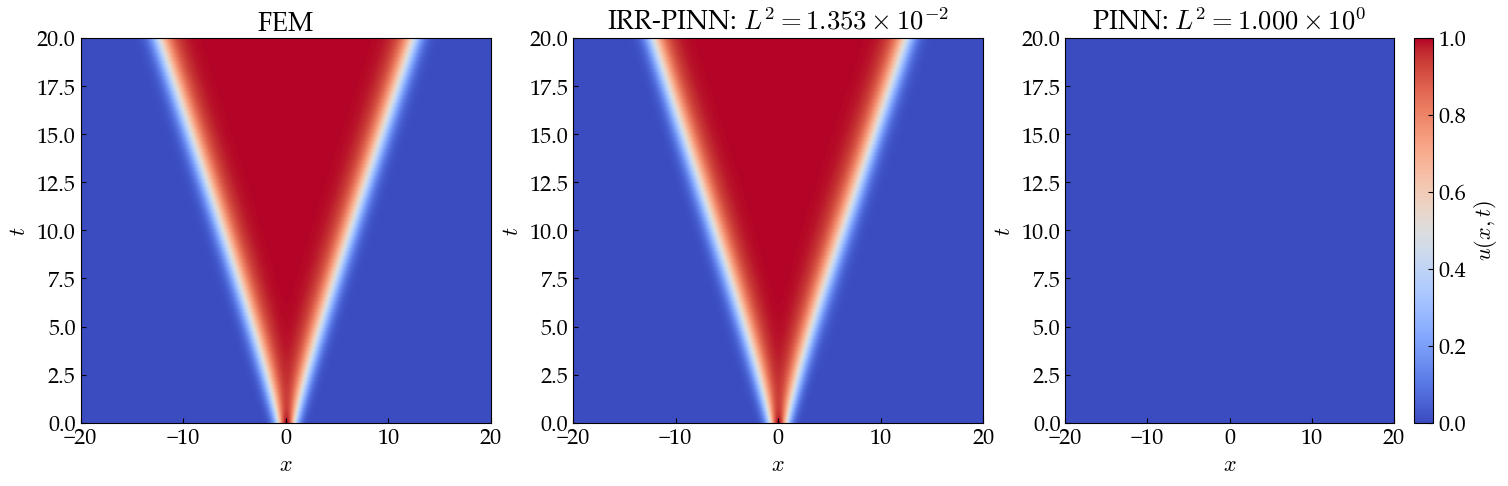

In [14]:
%matplotlib inline
xx, tt = jnp.meshgrid(mesh, times)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ax = axes[0]

def sci_to_latex(num, precision=3, prefix="L^2="):
    import re
    s = f"{num:.{precision}e}"  # 例如 1e-3 -> '1.000000e-03'

    # 分离基数和指数部分
    match = re.match(r"([\-]?\d+\.\d+)e([\-+]?\d+)", s)
    if match:
        base, exp = match.groups()
        exp = int(exp)  # 去掉多余的0
        return f"${prefix}{base}\\times 10^{{{exp}}}$"
    else:
        return f"${prefix}{num}$"
    
# plot FEM solution
ax.imshow(
    sol,
    origin="lower",
    aspect="auto",
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    extent=[mesh_fem.min(), mesh_fem.max(), times_fem.min(), times_fem.max()]
)
ax.set(xlabel="$x$", ylabel="$t$")
ax.set_title("FEM")

ax = axes[1]
xx_flat = xx.flatten()[:, None]
tt_flat = tt.flatten()[:, None]
pred_flat = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params, xx_flat, tt_flat)
pred = pred_flat.reshape(xx.shape)
error = jnp.linalg.norm(pred - sol) / jnp.linalg.norm(sol)
# error_str = "$L^2=" + f"{error:.3e}".replace("e", r"\times 10^{") + "}$"
error_str = sci_to_latex(error, precision=3, prefix="L^2=")
ax.imshow(
    pred,
    origin="lower",
    aspect="auto",
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    extent=[mesh_fem.min(), mesh_fem.max(), times_fem.min(), times_fem.max()]
)
ax.set(xlabel="$x$", ylabel="$t$")
ax.set_title(f"IRR-PINN: "+ error_str)

ax = axes[2]
pred_flat_noirr = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params_noirr, xx_flat, tt_flat)
pred_noirr = pred_flat_noirr.reshape(xx.shape)
error_noirr = jnp.linalg.norm(pred_noirr - sol) / jnp.linalg.norm(sol)
# error_str_noirr = "$L^2=" + f"{error_noirr:.3e}".replace("e", r"\times 10^{") + "}$"
error_str_noirr = sci_to_latex(error_noirr, precision=3, prefix="L^2=")
im = ax.imshow(
    pred_noirr,
    origin="lower",
    aspect="auto",
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    extent=[mesh_fem.min(), mesh_fem.max(), times_fem.min(), times_fem.max()]
)
ax.set(xlabel="$x$", ylabel="$t$")
ax.set_title(f"PINN: "+ error_str_noirr) 

# add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("$u(x,t)$")

# fig.savefig("./figures/travelling_wave_sol.png", dpi=300, bbox_inches='tight')
# fig.savefig("./figures/travelling_wave_sol.pdf", dpi=300, bbox_inches='tight')


[Text(0.5, 0, '$x$'), Text(0, 0.5, 'Solution $u$')]

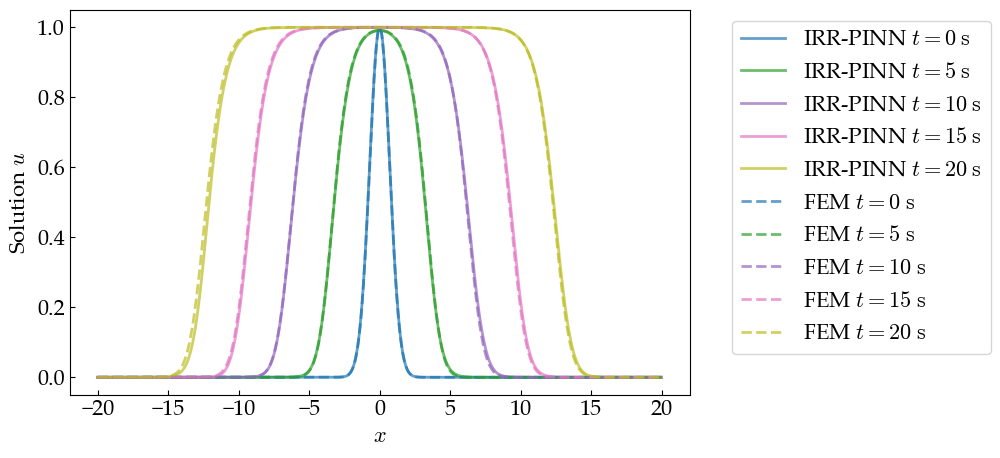

In [6]:
ts = [0.0, 5.0, 10.0, 15.0, 20.0]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for idx, t in enumerate(ts):
    t_c = t / cfg.Tc
    t_idx = jnp.argmin(jnp.abs(times - t_c))
    ax.plot(
        mesh_fem, pred[t_idx, :],
        label=f"IRR-PINN " + rf"$t={int(t)} \;\mathrm{{s}}$",
        color=plt.cm.tab10(idx / len(ts)),
        linestyle="solid",
        linewidth=2,
        alpha=0.7
    )
    
for idx, t in enumerate(ts):
    t_c = t / cfg.Tc
    t_idx = jnp.argmin(jnp.abs(times - t_c))
    ax.plot(
        mesh_fem, sol[t_idx, :],
        label=f"FEM " + rf"$t={int(t)} \;\mathrm{{s}}$",
        color=plt.cm.tab10(idx / len(ts)),
        linestyle="dashed",
        linewidth=2,
        alpha=0.7
    )
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)
ax.set(xlabel="$x$", ylabel="Solution $u$")
# fig.savefig("./figures/travelling_wave_timesnap.png", dpi=300, bbox_inches='tight')
# fig.savefig("./figures/travelling_wave_timesnap.pdf", dpi=300, bbox_inches='tight')

[Text(0.5, 0, '$x$'), Text(0, 0.5, 'Solution $u$')]

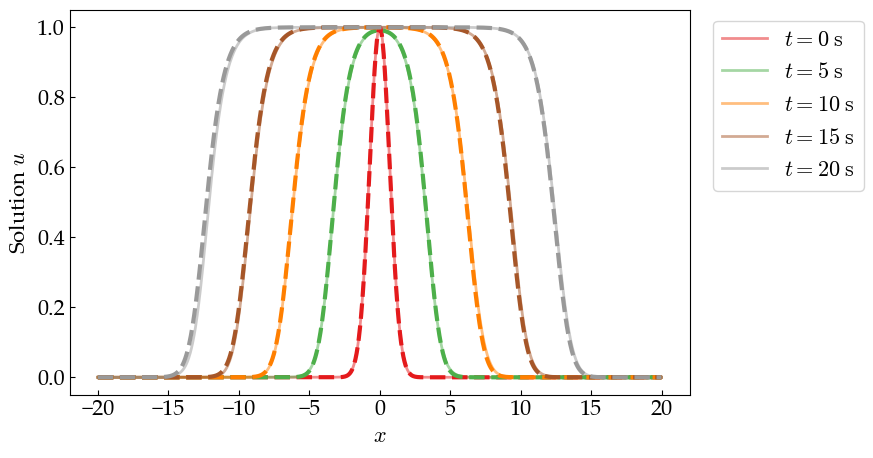

In [7]:
ts = [0.0, 5.0, 10.0, 15.0, 20.0]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for idx, t in enumerate(ts):
    t_c = t / cfg.Tc
    t_idx = jnp.argmin(jnp.abs(times - t_c))
    ax.plot(
        mesh_fem, pred[t_idx, :],
        label=rf"$t={int(t)} \;\mathrm{{s}}$",
        color=plt.cm.Set1(idx / (len(ts)-1)),
        linestyle="solid",
        linewidth=2,
        alpha=0.5
    )
    
for idx, t in enumerate(ts):
    t_c = t / cfg.Tc
    t_idx = jnp.argmin(jnp.abs(times - t_c))
    ax.plot(
        mesh_fem, sol[t_idx, :],
        # label=f"FEM " + rf"$t={int(t)} \;\mathrm{{s}}$",
        color=plt.cm.Set1(idx / (len(ts)-1)),
        linestyle="dashed",
        linewidth=3,
        alpha=1.0,
    )
    
# add text into the legend: dashed line for FEM, solid line for IRR-PINN
# handles, labels = ax.get_legend_handles_labels()
# from matplotlib.lines import Line2D
# custom_lines = [Line2D([0], [0], color='black', lw=2, linestyle='solid'),
#                 Line2D([0], [0], color='black', lw=2, linestyle='dashed')]
# handles = handles + custom_lines
# labels = labels + ['IRR-PINN', 'FEM']
# ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left',)

# ax.text(1.02, 0.5, 'Solid: IRR-PINN\nDashed: FEM', transform=ax.transAxes, 
#         horizontalalignment='left',
#         verticalalignment='top', )
    
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left',)
ax.set(xlabel="$x$", ylabel="Solution $u$")
# fig.savefig("./figures/travelling_wave_timesnap.png", dpi=300, bbox_inches='tight')
# fig.savefig("./figures/travelling_wave_timesnap.pdf", dpi=300, bbox_inches='tight')

In [13]:
epochs = jnp.arange(0, 40001, 200)
error_log = []
error_log_noirr = []

for epoch in epochs:
    state = ckpt.restore(f"/root/autodl-tmp/tf-logs/genes_prop/irr/baseline-40k/model-{epoch}/")
    state_noirr = ckpt.restore(f"/root/autodl-tmp/tf-logs/genes_prop/noirr/baseline-40k/model-{epoch}/")
    params = state["params"]
    params_noirr = state_noirr["params"]
    pred_flat = vmap(
        pinn.net_u, in_axes=(None, 0, 0)
    )(params, xx_flat, tt_flat)
    pred = pred_flat.reshape(xx.shape)
    error = jnp.linalg.norm(pred - sol) / jnp.linalg.norm(sol)
    error_log.append(error)
    
    pred_flat_noirr = vmap(
        pinn.net_u, in_axes=(None, 0, 0)
    )(params_noirr, xx_flat, tt_flat)
    pred_noirr = pred_flat_noirr.reshape(xx.shape)
    error_noirr = jnp.linalg.norm(pred_noirr - sol) / jnp.linalg.norm(sol)
    error_log_noirr.append(error_noirr)

The final relative L2 error of IRR-PINN is 1.35e-02
The final relative L2 error of PINN is 1.00e+00
The minimum relative L2 error of IRR-PINN is 1.02e-02
The minimum relative L2 error of PINN is 9.94e-01


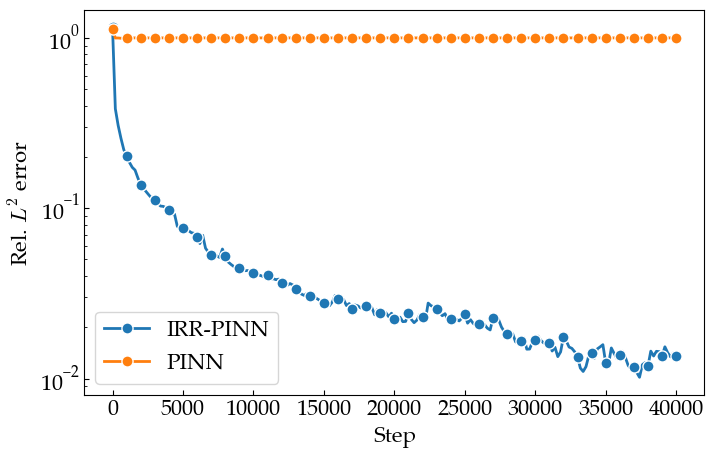

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(epochs, error_log, label="IRR-PINN", marker="o", markeredgecolor="white", markersize=8, markeredgewidth=1, lw=2, markevery=5)
ax.plot(epochs, error_log_noirr, label="PINN", marker="o", markeredgecolor="white", markersize=8, markeredgewidth=1, lw=2, markevery=5)

ax.set(ylabel="Rel. $L^2$ error",
       xlabel="Step", yscale="log")
ax.legend()
fig.savefig("figures/travelling-wave-error-log.png", dpi=300, bbox_inches='tight')
fig.savefig("figures/travelling-wave-error-log.pdf", dpi=300, bbox_inches='tight')
print("The final relative L2 error of IRR-PINN is {:.2e}".format(error_log[-1]))
print("The final relative L2 error of PINN is {:.2e}".format(error_log_noirr[-1]))
print("The minimum relative L2 error of IRR-PINN is {:.2e}".format(jnp.min(jnp.array(error_log))))
print("The minimum relative L2 error of PINN is {:.2e}".format(jnp.min(jnp.array(error_log_noirr))))

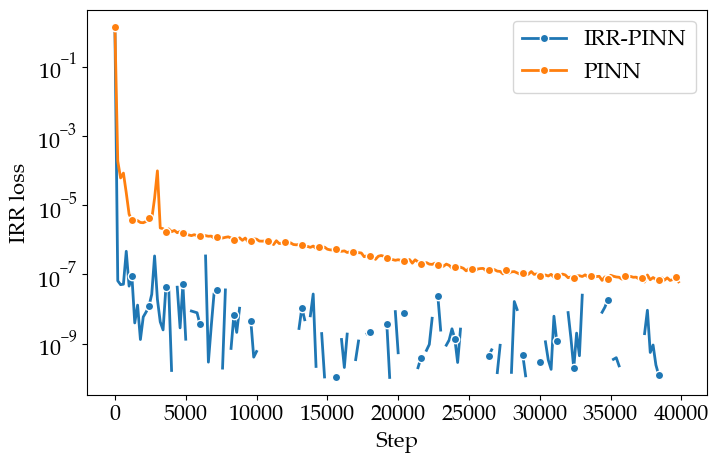

In [3]:
import pandas as pd

%matplotlib inline
error_log = pd.read_csv("./logs-eval/run-genes_prop_irr_baseline-40k-tag-loss_irr_x.csv")
error_log_noirr = pd.read_csv("./logs-eval/run-genes_prop_noirr_baseline-40k-tag-loss_irr_x.csv")

error_log = error_log[error_log["Step"] < 40000]
error_log_noirr = error_log_noirr[error_log_noirr["Step"] < 40000]

# error_log["Value"][error_log["Value"] < 1e-10] = jnp.nan
# error_log_noirr["Value"][error_log_noirr["Value"] < 1e-10] = jnp.nan
error_log.loc[error_log["Value"] < 1e-10, "Value"] = jnp.nan
error_log_noirr.loc[error_log_noirr["Value"] < 1e-10, "Value"] = jnp.nan
# error_log.dropna(inplace=True, how='any')
# error_log_noirr.dropna(inplace=True, how='any')


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(error_log["Step"], error_log["Value"], label="IRR-PINN", lw=2, markevery=6,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.plot(error_log_noirr["Step"], error_log_noirr["Value"], label="PINN", lw=2,markevery=6,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.set(ylabel="IRR loss", xlabel="Step", yscale="log")
ax.legend(loc="upper right",)
fig.savefig("figures/travelling-wave-irr-loss-log.png", dpi=300, bbox_inches='tight')
fig.savefig("figures/travelling-wave-irr-loss-log.pdf", dpi=300, bbox_inches='tight')

